In [1]:
import pandas as pd
import numpy as np
import keras
import sklearn
from sklearn.neural_network import MLPClassifier
import olac
from copy import deepcopy
from IPython import display
import functools 
import os

import tqdm
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import clone
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.kernel_approximation import RBFSampler

import warnings
warnings.filterwarnings('ignore')



Using TensorFlow backend.


In [2]:
% load_ext autoreload
% autoreload 2
% matplotlib inline


In [3]:
def get_grid():
    gridpoints = np.linspace(-10, 10, 250)
    grid = []
    for y in gridpoints:
        for x in gridpoints:
            grid.append([x, y])
    return np.array(grid)

grid = get_grid()

In [4]:
def scale_generator(original_generator):
    @functools.wraps(original_generator)
    def wrapper(x_min, x_max, dp0=0, dp1=1, *args, **kwargs):
        or_output = original_generator(*args, **kwargs)
        
        x_shift = x_min

        dp = np.array((dp0, dp1))
        x_min -= x_shift
        x_max -= x_shift
        for point in or_output:
            point[:2] -= x_shift
            point[:2] = dp[0] + (point[:2] - x_min)*(dp[1] - dp[0])/(x_max - x_min)
            yield point
    return wrapper

In [5]:
transformer = RBFSampler(n_components=100, gamma=0.075)
transformer.fit_transform(grid)

@scale_generator
def new_generator(generator, *args, **kwargs):
    gen = eval(generator)(*args, **kwargs)
    return gen

In [6]:
import imageio
def plot_history(pipeline, test_set, save_gif=False, gen_name=None, trans=None, plot_cost=False):
    plt.rcParams['figure.figsize']=(10,5)
    X=[]
    y=[]
    X_val = []
    ind=0
    
    cost = [100]
    test_df = olac.utils.queue_point_list_to_df(test_set)

    y_true = test_df['y_true']
    y_pred = test_df['y_pred']

    acc2 = np.array_split(y_true == y_pred, len(pipeline.predictor.model_hist))
    X_in = np.array_split(test_df[['x0','x1']].values, len(pipeline.predictor.model_hist))
    
    y_true = np.array_split(test_df['y_true'], len(pipeline.predictor.model_hist))
    y_pred = np.array_split(test_df['y_pred'], len(pipeline.predictor.model_hist))
    
    acc = []

    cols = np.array(['g','b'])
    window=100
    filenames = []
    if trans is not None:
        gridt = trans.transform(grid)
    else:
        gridt = grid

    for i, mod in enumerate(pipeline.predictor.model_hist):
         if i % 2 == 0:
            new_model = clone(pipeline.model)
            if hasattr(pipeline.model, 'coefs_'):
                new_model.coefs_, new_model.intercepts_, new_model.classes_,\
                new_model.n_outputs_, new_model.n_layers_, new_model.out_activation_,\
                new_model._label_binarizer = mod[:-2]
            elif hasattr(pipeline.model, 'coef_'):
                new_model.coef_, new_model.intercept_, new_model.classes_ = mod[:-2]

            X.append(mod[-2])
            y.append(mod[-1].ravel())

            cost.append(cost[-1] - len(np.hstack(y[-1]))+((np.hstack(y[-1])==1).sum()*10))

    #         return cost

            if trans is not None:
                Xt = trans.transform(np.vstack(X)[-window:, :])
            else:
                Xt = X

            try:
                Z = new_model.predict_proba(gridt)[:, 0].reshape(250, 250)
                yPred = new_model.predict(Xt)
            except AttributeError:
                Z = new_model.decision_function(gridt).reshape(250, 250)
                yPred = new_model.predict(Xt)

            plt.subplot(121)
            plt.contourf(np.linspace(0, 1, 250),
                     np.linspace(0, 1, 250),
                     Z, 30, cmap='RdBu_r')
            ax = plt.gca()
            plt.colorbar(ax=ax)
            plt.contour(np.linspace(0, 1, 250),
                     np.linspace(0, 1, 250),
                     Z, [0.5])
            plt.scatter(*np.vstack(X)[-window:,:].T, c=cols[np.hstack(y)[-window:].astype(int)], alpha=.8)
            ind += len(mod[-2])
            plt.xlim([0, 1])
            plt.ylim([0, 1])

            plt.title('Epoch: '+str(i))

            acc.append(np.hstack(y)[-window:]==yPred[-window:])

            plt.subplot(122)
            acc_plot = pd.Series(np.hstack(acc)).rolling(window).mean().values
            plt.plot(acc_plot, c ='g', label='accuracy')



            plt.ylim([0, 1.05])
            plt.xlim([0, len(np.hstack(acc))+100])
            plt.title(f'{(acc_plot[-1]*100).round(2)}% -- Profit: ${cost[-1]}')

            if plot_cost:
                ax1 = plt.gca()
                ax2 = ax1.twinx()
                ax2.plot(np.linspace(0, len(np.hstack(acc)), num=len(cost)), cost, c='b', label='Profit')
                clrs=sns.hls_palette(2)
                ax2.scatter(np.linspace(0, len(np.hstack(acc)), num=len(cost)), cost,
                            c=np.array(clrs)[(np.array(cost)>0).astype(int)], s=2, label='Profit')
            plt.legend()

            f = plt.gcf()

            model_name = str(pipeline.model.__class__).split('.')[-1].split("'")[0]
            gener_name = gen_name
            f.suptitle(f"Model: {model_name}\nDataSet: {gener_name}")

            if save_gif:
                filenames.append(f'tmp/gif{model_name}_{gener_name}_{i}.png')
                f.savefig(filenames[-1])

            display.clear_output(wait=True)
            plt.show()


    if save_gif:
        images = []
        for filename in filenames:
            images.append(imageio.imread(filename))
        imageio.mimsave(f'tmp/{model_name}_{gener_name}.gif', images)

        if os.path.exists(f'tmp/{model_name}_{gener_name}.gif'):
            for filename in filenames:
                os.remove(filename)



In [7]:
class NewPredictor(olac.pipeline.OnlinePredictor):
    def __init__(self, verbose, transformer):
        super().__init__()
        self.model_hist = []
        self.verbose = verbose
        self.transformer = transformer
        self.models = []
        self.grid = self.get_grid()
        
    def transform(self, X_train):
        if hasattr(self.transformer, 'transform'):
            return self.transformer.transform(X_train)
        else:
            return X_train
        
        
    def train_pipeline_model(self, pipeline):
        points = pipeline.training_queue.get_all()

        X_train = np.vstack([np.array(p.point) for p in points])
        y_train = np.array([p.true_label for p in points])
        
        if self.verbose:
            print(
                f'Predictor:\t{len(points)} new points available, updating ...'
            )

        pipeline.model.partial_fit(self.transform(X_train), y_train, classes=[0, 1])
        try:
            mod = deepcopy(pipeline.model)
            self.models.append(mod)
            if hasattr(mod, 'coef_'):
                self.model_hist.append((mod.coef_, mod.intercept_, mod.classes_, 
                                        X_train, y_train))
            elif hasattr(mod, 'coefs_'):
                self.model_hist.append((mod.coefs_, mod.intercepts_.copy(),
                                        mod.classes_.copy(), mod.n_outputs_,
                                        mod.n_layers_, mod.out_activation_,
                                        mod._label_binarizer, X_train, y_train))
        except AttributeError:
            pass

    def get_grid(self):
        gridpoints = np.linspace(-10, 10, 250)
        grid = []
        for y in gridpoints:
            for x in gridpoints:
                grid.append([x, y])
        return np.array(grid)
    
    def do_prediction(self, pipeline, x,):
        """
        Make a prediction. If the model has not yet been fit (burn-in phase),
        return NaNs.
        """
        xt = self.transform([x])
#         if self.verbose:
#             print(f"Making predictions for {len(x)} points")
        try:
            y_pred = pipeline.model.predict(xt)

            # certainty measure not standard across sklearn
            # prefer predict_proba, else take decision_function
            if hasattr(pipeline.model, 'predict_proba'):
                prob = pipeline.model.predict_proba(xt)
#                 self.models.append(pipeline.model.predict_proba(self.transform(self.grid))[:,0].reshape(250,250))
            elif hasattr(pipeline.model, 'decision_function'):
                prob = pipeline.model.decision_function(xt)
#                 self.models.append(pipeline.model.decision_function(self.transform(self.grid))[:].reshape(250,250))
            else:
                prob = np.nan

        except (sklearn.exceptions.NotFittedError, AssertionError):
            # still burning in, return NaNs.
            y_pred = np.nan
            prob = np.nan

        return y_pred, prob


In [8]:
class CertaintyLabeller(olac.pipeline.ThresholdLabeller):
    
    def buy_labels(self, pipeline):
        """Get all the points from the labelling queue and label them with
        some probability. """
        labelled_points = []
        unlabelled_points = []

        points = pipeline.labelling_queue.get_all()
        
        for point in points:
            # self.prob percent chance of being labelled
            if point.to_tuple()[3] > self.prob:
                self.labels_bought += 1
                labelled_points.append(point)
            else:
                unlabelled_points.append(point)

        if self.verbose:
            print(f'Labeller:\tLabelled {len(labelled_points)} new points')

        return labelled_points, unlabelled_points    


## Making the pipelines and plots

In [9]:
data = list(new_generator(generator='olac.data_generators.satellites', x_min=-10, x_max=10, n_points=100))

In [10]:
transformer = RBFSampler(n_components=100, gamma=0.09)
# transformer = SkewedChi2Sampler(0.1, 100)
gridt = transformer.fit_transform(get_grid())
sns.set_context("notebook")

pa_pipeline = olac.pipeline.Pipeline(
    olac.data_generators.delayed_generator(data, delay=0.1),
    MLPClassifier((64,32,), batch_size=1, learning_rate='adaptive', early_stopping=False, 
                    alpha=0.0003, warm_start=False),
    olac.pipeline.OfflinePredictor(batch_size=10, verbose=True),
    olac.pipeline.ThresholdLabeller(threshold=10, prob=0.1, verbose=True))
    
pa_train_set, pa_test_set = pa_pipeline.run()
# plot_history(pa_pipeline, pa_train_set, save_gif=False, trans=transformer)
# plt.close()

Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 2 new points
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 2 new points
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 3 new points
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 2 new points
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 0 new points
Labeller:	Threshold met, 11 new points available in queue
Labeller:	Labelled 0 new points


In [11]:
plotter = olac.vis.Plotter(window=10)
plotter.plot_history(pa_pipeline, pa_test_set, save_gif=False)

AttributeError: 'OfflinePredictor' object has no attribute 'model_hist'

§x§§§§§

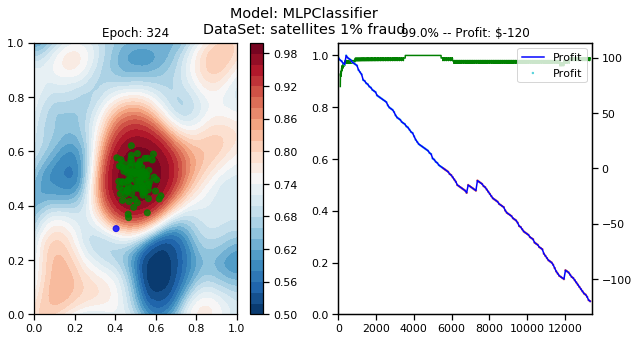

In [61]:

test = plot_history(pa_pipeline, pa_train_set, gen_name='satellites 1% fraud',
                    save_gif=True, trans=transformer, plot_cost=True)
plt.close()

In [ ]:
test = plot_history(pa_pipeline, pa_train_set, gen_name='satellites w cost',
                    save_gif=True, trans=transformer, plot_cost=True)
plt.close()

In [8]:
data_new = pd.read_csv('temp.csv', index_col=0)

In [9]:
transformer = RBFSampler(n_components=100, gamma=0.09)
transformer.fit_transform(get_grid())
sns.set_context("notebook")


p_pipeline = olac.pipeline.Pipeline(
    olac.data_generators.delayed_generator(data_new.as_matrix(), delay=0.2),
    MLPClassifier((64,32,), batch_size=1, learning_rate='adaptive', early_stopping=False, 
                    alpha=0.0003, warm_start=False),
    NewPredictor(verbose=False, transformer=transformer),
    olac.pipeline.ThresholdLabeller(threshold=10, prob=0.6, verbose=False))
    
p_test_set, p_train_set = p_pipeline.run()
# plot_history(p_pipeline, p_train_set, save_gif=False, trans=transformer)
# plt.close()

In [33]:
plot_history(p_pipeline, p_test_set, save_gif=False, trans=transformer,
             gen_name='roving balls', plot_cost=True)
plt.close()

KeyboardInterrupt: 

In [44]:
def get_cost(df_train, budget, gain_factor=2):
    """ Calculate the cost based on the labels you retreived
    """
    seen = []
    total_cost = []
    gain = 0
    df = df_train.loc[~df_train['y_pred'].isnull(),:]
    for runtime, row in enumerate(df[['y_pred','y_true']].values):
        seen.append(row)
        investigate_cost = len(seen)
        gain += ((row[1] == 1)).astype(float)*gain_factor

        total_cost.append(budget - investigate_cost+gain)
        
#         if total_cost[-1] < 0:
#             return 'Loss', np.array(total_cost), runtime
        
#     return np.array(total_cost)
    return 'Win', np.array(total_cost), runtime

In [18]:
df = olac.utils.queue_point_list_to_df(p_train_set)


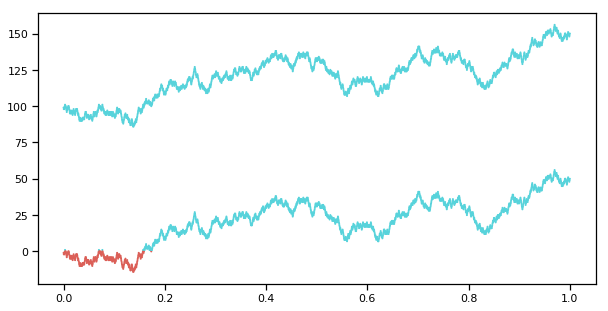

In [43]:
_, cost, runtime = get_cost(df, 100, gain_factor=2)
_, cost2, runtime2 = get_cost(df, 0, gain_factor=2)
clrs = sns.hls_palette(2)
plt.scatter(np.linspace(0,1,len(cost)), cost, c=np.array(clrs)[(cost>0).astype(int)], s=1)
plt.scatter(np.linspace(0,1,len(cost2)), cost2, c=np.array(clrs)[(cost2>0).astype(int)], s=1)

## 'gridsearch' of budget vs gain from catching fraud

In [ ]:
df = olac.utils.queue_point_list_to_df(pa_train_set)
final = []
all_costs = []
for budget in tqdm_notebook(np.arange(1, 100,step=10)):
    for gain_factor in np.arange(1, 10, step=0.1):
        win_lose, cost, runtime = get_cost(df, budget, gain_factor)
        final.append([budget, gain_factor, runtime, win_lose])
        all_costs.append(cost)

In [ ]:
final_df = pd.DataFrame(final, columns = ['budget','gain_factor','runtime', 'win_lose'])


In [ ]:
plt.scatter(np.linspace(0,final[i][2],len(all_costs[10])), all_costs[10], c=np.array(clrs)[(all_costs[10]>0).astype(int)], s=1)

In [ ]:
cost = get_cost(olac.utils.queue_point_list_to_df(p_train_set), budget = 100)
df = olac.utils.queue_point_list_to_df(p_train_set)
acc = (df['y_true'] == df['y_pred']).rolling(window=100).mean()

## Running 3 models for 3 datasets

In [1]:
transformer = RBFSampler(n_components=100, gamma=0.075)
transformer.fit_transform(get_grid());

NameError: name 'RBFSampler' is not defined

In [ ]:
models = [SGDClassifier(), 
          MLPClassifier((16, 8), learning_rate='adaptive', batch_size=1, alpha=0.0003,),
          PassiveAggressiveClassifier()]
data_generators = [new_generator(generator='olac.data_generators.satellites', x_min=-10, x_max=10, n_points=2000, contamination=0.1),
                   new_generator(generator='olac.data_generators.roving_balls', x_min=-10, x_max=10, steps=2000),
                   new_generator(generator='olac.data_generators.cluster_generator', x_min=0, x_max=1000, n_points=2000)]

In [ ]:
pipelines = []

for gen in data_generators:
    generator = list(gen)
    for mod in models:
        mod_name = str(mod.__class__).split('.')[-1].split("'")[0]
        print(mod_name)
        if mod_name == 'MLPClassifier':
            trans = None
        else:
            trans = transformer
        print(gen.__name__)
        model = clone(mod)
        pipeline = olac.pipeline.Pipeline(data_generator=olac.data_generators.delayed_generator(generator, delay=0.25),
                                          model=model,
                                          predictor=NewPredictor(verbose=False, transformer=trans),
                                          labeller=olac.pipeline.ThresholdLabeller(threshold=20,
                                                                                   prob=.6, verbose=False))
        test_set, train_set = pipeline.run()
        pipelines.append((pipeline, train_set, test_set))
        print('-'*20)

In [ ]:
gen_names = ['satellites', 'satellites', 'satellites', 
                 'roving_balls','roving_balls','roving_balls',
                 'clusters', 'clusters', 'clusters']
for i, (pipeline, train_set, test_set) in enumerate(pipelines):
    plot_history(pipeline, train_set, save_gif=True, gen_name=gen_names[i])
    plt.show()

In [12]:
(1200+2912)/(21947+15128)

0.11091031692515171

In [16]:
import re
re.findall('(?<=\.)\w+','dit.is.een.string')[-1]


'string'